# Detecção de Fraude em contratos de seguros:Exploração de Dados

##Background

Este notebook é a primeira parte de uma série de notebooks que faz a demonstrarão de como preparar, treinar e implantar um modelo que detecta fraudes em contratos. Neste notebook, vamos nos concentrar na exploração de dados. Você pode optar por executar este notebook sozinho ou em sequência com os outros notebooks listados abaixo. Consulte o [README.md](README.md) para obter mais informações sobre este caso de uso implementado por esta série de notebooks.


1. **[Detecção de Fraude em contratos de seguros: exploração de dados](./0-AutoClaimFraudDetection.ipynb)**
1. [Detecção de Fraude em contratos de seguros: preparação de dados, processo e recursos de armazenamento](./1-data-prep-e2e.ipynb)
1. [Detecção de Fraude em contratos de seguros: treinar, verificar viés, ajustar, registrar linhagem e registrar um modelo](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
1. [Detecção de Fraude em contratos de seguros: mitigar, treinar, registrar e implantar modelo imparcial](./3-mitigate-bias-train-model2-registry-e2e.ipynb)

## Conjuntos de Dados e Análise Exploratória

O conjunto de dados é gerado sinteticamente e consiste em conjuntos de dados de clientes e reivindicações.
Aqui vamos carregá-los e fazer algumas visualizações exploratórias.

In [2]:
!pip install seaborn==0.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.0/285.0 kB 4.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [3]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns  # visualisation
import matplotlib.pyplot as plt  # visualisation

%matplotlib inline
sns.set(color_codes=True)

df_claims = pd.read_csv("./data/claims_preprocessed.csv", index_col=0)
df_customers = pd.read_csv("./data/customers_preprocessed.csv", index_col=0)

In [4]:
print(df_claims.isnull().sum().sum())
print(df_customers.isnull().sum().sum())

0
0


In [23]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   incident_severity                5000 non-null   float64
 1   num_vehicles_involved            5000 non-null   int64  
 2   num_injuries                     5000 non-null   int64  
 3   num_witnesses                    5000 non-null   int64  
 4   police_report_available          5000 non-null   float64
 5   injury_claim                     5000 non-null   int64  
 6   vehicle_claim                    5000 non-null   int64  
 7   total_claim_amount               5000 non-null   int64  
 8   incident_month                   5000 non-null   int64  
 9   incident_day                     5000 non-null   int64  
 10  incident_dow                     5000 non-null   int64  
 11  incident_hour                    5000 non-null   int64  
 12  fraud               

In [24]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_age               5000 non-null   int64  
 1   customer_education         5000 non-null   int64  
 2   months_as_customer         5000 non-null   int64  
 3   policy_deductable          5000 non-null   int64  
 4   policy_annual_premium      5000 non-null   int64  
 5   policy_liability           5000 non-null   int64  
 6   auto_year                  5000 non-null   int64  
 7   num_claims_past_year       5000 non-null   int64  
 8   num_insurers_past_5_years  5000 non-null   int64  
 9   customer_gender_male       5000 non-null   float64
 10  customer_gender_female     5000 non-null   float64
 11  policy_state_ca            5000 non-null   float64
 12  policy_state_wa            5000 non-null   float64
 13  policy_state_az            5000 non-null   float

Isso não deve retornar valores nulos em ambos os conjuntos de dados.

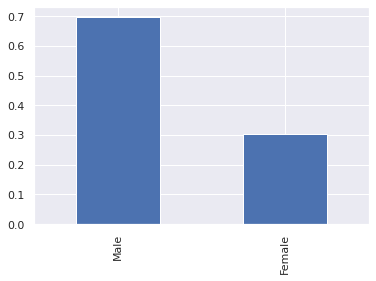

In [5]:
# plot the bar graph customer gender
df_customers.customer_gender_female.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Male", "Female"]);

O conjunto de dados é fortemente ponderado para clientes do sexo masculino.

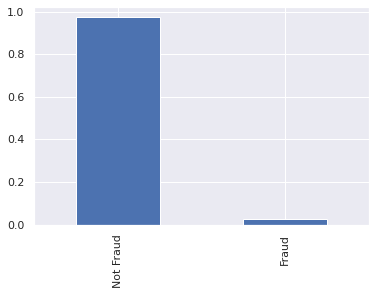

In [6]:
# plot the bar graph of fraudulent claims
df_claims.fraud.value_counts(normalize=True).plot.bar()
plt.xticks([0, 1], ["Not Fraud", "Fraud"]);

A esmagadora maioria das reivindicações são legítimas (ou seja, não fraudulentas).

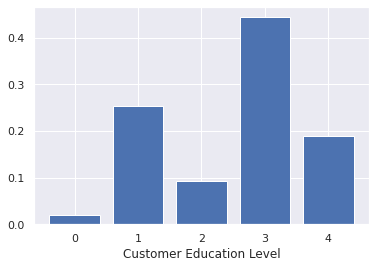

In [7]:
# plot the education categories
educ = df_customers.customer_education.value_counts(normalize=True, sort=False)
plt.bar(educ.index, educ.values)
plt.xlabel("Customer Education Level");

Text(0.5, 0, 'Total Claim Amount')

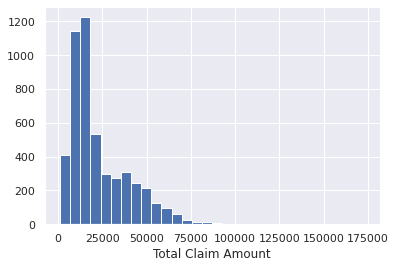

In [8]:
# plot the total claim amounts
plt.hist(df_claims.total_claim_amount, bins=30)
plt.xlabel("Total Claim Amount")

A maioria dos valores de pagamento está abaixo de US$ 25.000.

Text(0.5, 0, 'Number of claims per year')

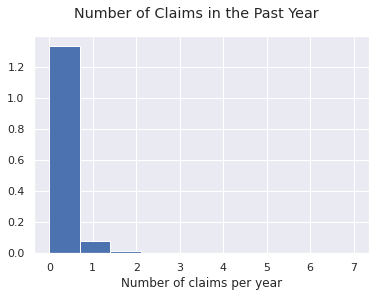

In [9]:
# plot the number of claims filed in the past year
df_customers.num_claims_past_year.hist(density=True)
plt.suptitle("Number of Claims in the Past Year")
plt.xlabel("Number of claims per year")

A maioria dos clientes não apresentou nenhuma reclamação no ano anterior, mas alguns apresentaram até 7 reclamações.

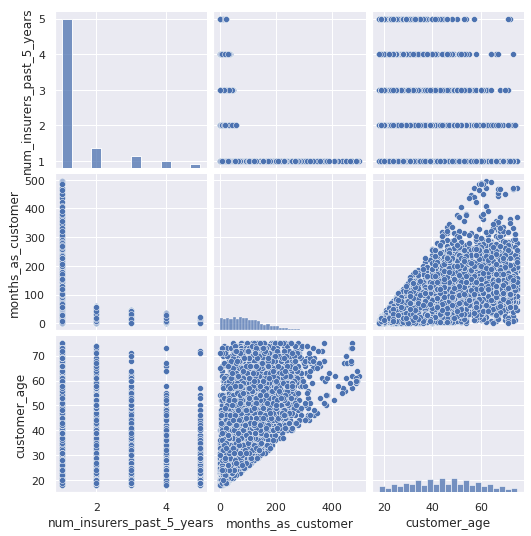

In [10]:
sns.pairplot(
    data=df_customers, vars=["num_insurers_past_5_years", "months_as_customer", "customer_age"]
);

Compreensivelmente, `months_as_customer` e `customer_age` são correlacionados entre si. Uma pessoa mais jovem dirige há menos tempo e, portanto, tem um potencial menor de quanto tempo pode ter sido um cliente.

Também podemos ver que `num_insurers_past_5_years` está negativamente correlacionado com `months_as_customer`. Se alguém frequentemente procurava diferentes seguradoras, provavelmente passava menos tempo como cliente dessa seguradora.

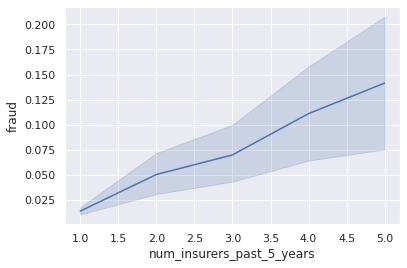

In [11]:
df_combined = df_customers.join(df_claims)
sns.lineplot(x="num_insurers_past_5_years", y="fraud", data=df_combined);

A fraude está positivamente correlacionada com o maior número de seguradoras nos últimos 5 anos. Clientes que trocaram de seguradora com mais frequência também tiveram maior prevalência de fraude.

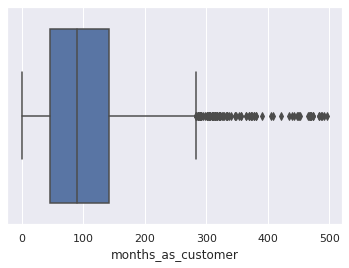

In [12]:
sns.boxplot(x=df_customers["months_as_customer"]);

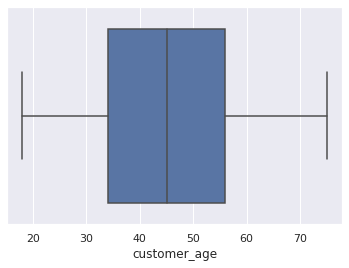

In [13]:
sns.boxplot(x=df_customers["customer_age"]);

Nossos clientes variam de 18 a 75 anos.

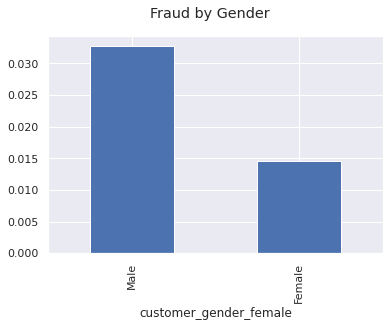

In [14]:
df_combined.groupby("customer_gender_female").mean()["fraud"].plot.bar()
plt.xticks([0, 1], ["Male", "Female"])
plt.suptitle("Fraud by Gender");

Reivindicações fraudulentas aparecem desproporcionalmente de clientes do sexo masculino.

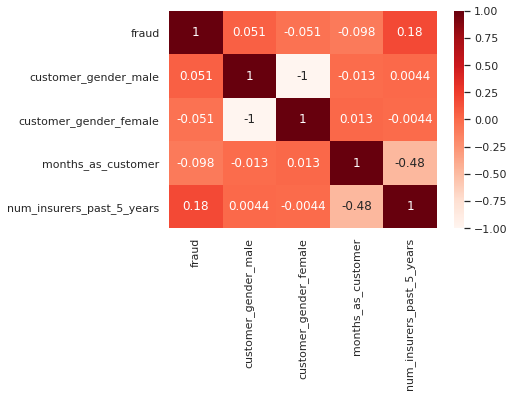

In [15]:
# Creating a correlation matrix of fraud, gender, months as customer, and number of different insurers
cols = [
    "fraud",
    "customer_gender_male",
    "customer_gender_female",
    "months_as_customer",
    "num_insurers_past_5_years",
]
corr = df_combined[cols].corr()

# plot the correlation matrix
sns.heatmap(corr, annot=True, cmap="Reds");

A fraude está correlacionada com ter mais seguradoras nos últimos 5 anos, e negativamente correlacionada com ser cliente por um período maior de tempo. Estes andam de mãos dadas e significam que os clientes de longa data são menos propensos a cometer fraudes.

### Conjuntos de dados combinados

Estivemos olhando para os conjuntos de dados individuais, agora vamos ver uma visão combinada (juntar).

In [16]:
import pandas as pd

df_combined = pd.read_csv("./data/claims_customer.csv")

In [17]:
df_combined = df_combined.loc[:, ~df_combined.columns.str.contains("^Unnamed: 0")]
# get rid of an unwanted column
df_combined.head()

,policy_id,incident_type_theft,policy_state_ca,policy_deductable,num_witnesses,policy_state_or,incident_month,customer_gender_female,num_insurers_past_5_years,customer_gender_male,...,policy_state_id,incident_hour,vehicle_claim,fraud,incident_type_collision,policy_annual_premium,policy_state_az,policy_state_wa,collision_type_rear,collision_type_front
0,1675,0,0,750,0,0,2,0,1,0,...,0,20,12000.0,0,0,3000,1,0,0,0
1,9,0,0,750,0,0,9,0,1,1,...,0,15,18500.0,0,1,3000,0,0,0,0
2,1687,0,1,750,0,0,7,1,1,0,...,0,16,17500.0,0,1,3000,0,0,0,0
3,1687,0,1,750,0,0,7,0,1,1,...,0,16,17500.0,0,1,3000,0,0,0,0
4,1692,0,0,750,2,0,6,1,1,0,...,0,8,21500.0,0,1,2800,1,0,0,1


In [18]:
df_combined.describe()

,policy_id,incident_type_theft,policy_state_ca,policy_deductable,num_witnesses,policy_state_or,incident_month,customer_gender_female,num_insurers_past_5_years,customer_gender_male,...,policy_state_id,incident_hour,vehicle_claim,fraud,incident_type_collision,policy_annual_premium,policy_state_az,policy_state_wa,collision_type_rear,collision_type_front
count,20000.00000,20000.000000,20000.0000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2500.50000,0.048200,0.6204,751.13000,0.866100,0.070000,6.713200,0.372400,1.412200,0.576500,...,0.02730,11.786800,17426.083700,0.030000,0.857200,2925.400000,0.113600,0.121000,0.220900,0.425400
std,1443.41173,0.214194,0.4853,13.57322,1.097921,0.255153,3.654396,0.483456,0.897291,0.494125,...,0.16296,5.337918,10043.773599,0.170591,0.349878,143.516096,0.317333,0.326135,0.414864,0.494416
min,1.00000,0.000000,0.0000,750.00000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,1000.000000,0.000000,0.000000,2150.000000,0.000000,0.000000,0.000000,0.000000
25%,1250.75000,0.000000,0.0000,750.00000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,...,0.00000,8.000000,10474.250000,0.000000,1.000000,2900.000000,0.000000,0.000000,0.000000,0.000000
50%,2500.50000,0.000000,1.0000,750.00000,0.000000,0.000000,7.000000,0.000000,1.000000,1.000000,...,0.00000,12.000000,15000.000000,0.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,0.000000
75%,3750.25000,0.000000,1.0000,750.00000,2.000000,0.000000,10.000000,1.000000,1.000000,1.000000,...,0.00000,16.000000,22005.500000,0.000000,1.000000,3000.000000,0.000000,0.000000,0.000000,1.000000
max,5000.00000,1.000000,1.0000,1100.00000,5.000000,1.000000,12.000000,1.000000,5.000000,1.000000,...,1.00000,23.000000,51051.000000,1.000000,1.000000,3000.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
combined_stats = []


for col in df_combined.columns:
    combined_stats.append(
        (
            col,
            df_combined[col].nunique(),
            df_combined[col].isnull().sum() * 100 / df_combined.shape[0],
            df_combined[col].value_counts(normalize=True, dropna=False).values[0] * 100,
            df_combined[col].dtype,
        )
    )

stats_df = pd.DataFrame(
    combined_stats,
    columns=["feature", "unique_values", "percent_missing", "percent_largest_category", "datatype"],
)
stats_df.sort_values("percent_largest_category", ascending=False)

,feature,unique_values,percent_missing,percent_largest_category,datatype
3,policy_deductable,8,0.0,98.94,int64
28,authorities_contacted_ambulance,2,0.0,97.45,int64
37,policy_state_id,2,0.0,97.27,int64
35,authorities_contacted_fire,2,0.0,97.20,int64
40,fraud,2,0.0,97.00,int64
36,driver_relationship_other,2,0.0,96.06,int64
16,driver_relationship_child,2,0.0,95.49,int64
27,policy_state_nv,2,0.0,95.23,int64
1,incident_type_theft,2,0.0,95.18,int64
23,num_claims_past_year,8,0.0,93.28,int64


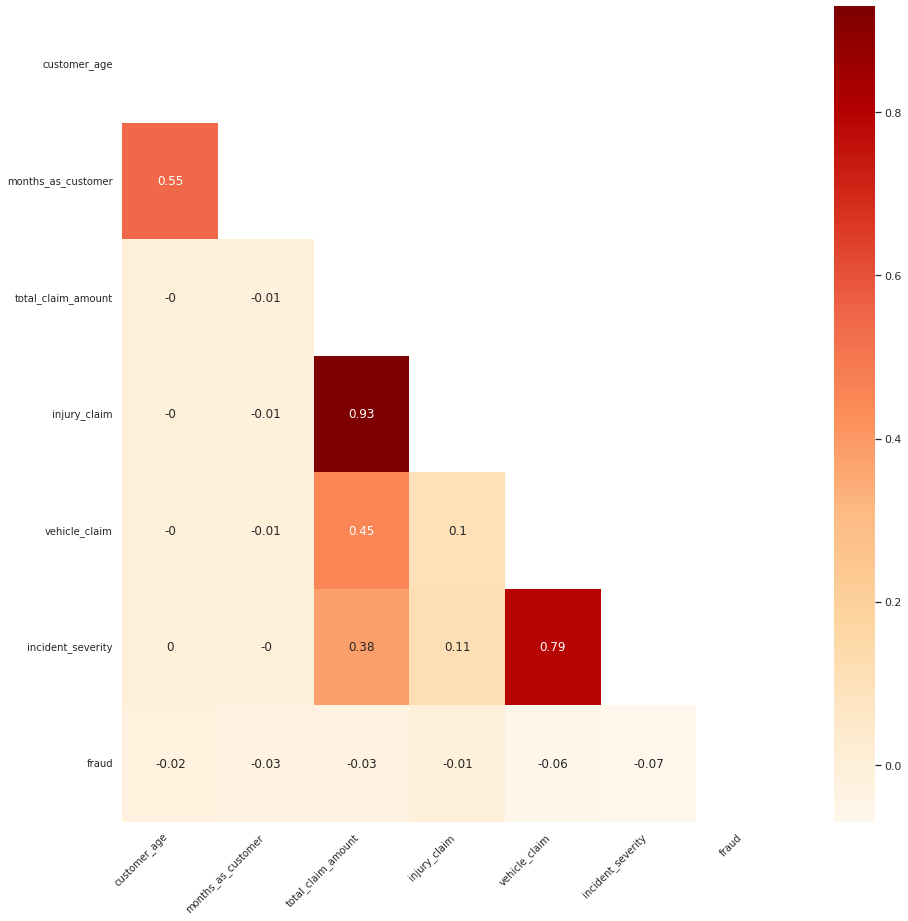

In [20]:
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("white")

corr_list = [
    "customer_age",
    "months_as_customer",
    "total_claim_amount",
    "injury_claim",
    "vehicle_claim",
    "incident_severity",
    "fraud",
]

corr_df = df_combined[corr_list]
corr = round(corr_df.corr(), 2)

fix, ax = plt.subplots(figsize=(15, 15))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True, cmap="OrRd")

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10, ha="right", rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10, va="center", rotation=0)

plt.show()